# Dependencies

In [1]:
%pip install opencv-python
%pip install mediapipe
%pip install tensorflow
%pip install matplotlib
%pip install scikit-learn
%pip install pillow

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:
import cv2
import mediapipe as mp
import numpy as np
import os
from matplotlib import pyplot as plt
import winsound
from PIL import Image
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import multilabel_confusion_matrix, accuracy_score
from scipy import stats

# Feature Extraction
<img src="https://www.researchgate.net/profile/Jungpil-Shin/publication/362351225/figure/fig3/AS:1183521695645696@1659184969422/Mediapipe-detects-33-nodes-of-the-human-pose.ppm" width="400px">

In [3]:
#Feed Input Source
feed = 1

In [4]:
mp_holistic = mp.solutions.holistic # Holistic model
mp_drawing = mp.solutions.drawing_utils # Drawing utilities

In [5]:
def mediapipe_detection(image, model):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # COLOR CONVERSION BGR 2 RGB
    image.flags.writeable = False                  # image is no longer writeable
    results = model.process(image)                 # Make prediction
    image.flags.writeable = True                   # image is now writeable 
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR) # COLOR COVERSION RGB 2 BGR
    return image, results

In [6]:
def draw_landmarks(image, results):
    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS) # Draw pose connections

In [7]:
# cap = cv2.VideoCapture(feed)
# with  mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
#     while cap.isOpened(): 
#         ret, frame = cap.read()

#         image, results = mediapipe_detection(frame, holistic)
        
#         # Render detections
#         draw_landmarks(image, results)

#         cv2.imshow('Gait ID', image)
        
#         if cv2.waitKey(10) & 0xFF == 27:
#             break
#     cap.release()
#     cv2.destroyAllWindows()

In [8]:
def extract_keypoints(results):
    pose = np.array([[res.x, res.y, res.z, res.visibility] for res in results.pose_landmarks.landmark]).flatten() if results.pose_landmarks else np.zeros(33*4)
    return pose

In [9]:
# result_test = extract_keypoints(results)
# result_test

# Setup Folders

In [86]:
# Path for exported data, numpy arrays
# DATA_PATH = os.path.join('Temp_Dataset') 
DATA_PATH = os.path.join('Custom_Gait_Dataset_V.4')
EXPORTED = os.path.join('Exported')

# Persons that we try to detect
persons = np.array(['Hamza Tharwat','Lance Moheb','Mina Nady','Mohmed Youssef','Omar Amin','Romario Nagy','Seif Ibrahim','Ziad Diaa'])
# persons = np.array(['Lance Moheb'])

# 10 videos worth of data
no_sequences = 10

# Videos are going to be 30 frames in length
sequence_length = 90

persons_len = len(persons)
total_sequences = persons_len*no_sequences

# Capturing Dataset

In [43]:
for person in persons:
    for sequence in range(no_sequences):
        try: 
            os.makedirs(os.path.join(EXPORTED, person, str(sequence)))
        except:
            pass

In [12]:
# cap = cv2.VideoCapture(feed)
# # Set mediapipe model 
# with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    
#     # NEW LOOP
#     # Loop through persons
#     for person in persons:
#         for sequence in range(no_sequences):
#             for frame_num in range(sequence_length):

#                 # Read feed
#                 ret, frame = cap.read()

#                 # Make detections
#                 image, results = mediapipe_detection(frame, holistic)

#                 # Draw landmarks
#                 draw_landmarks(image, results)
                
#                 # NEW Apply wait logic
#                 if frame_num == 0: 
#                     cv2.putText(image, 'STARTING COLLECTION', (120,200), 
#                             cv2.FONT_HERSHEY_SIMPLEX, 1, (0,255, 0), 1, cv2.LINE_AA)
#                     cv2.putText(image, 'Collecting frames for {} Video, frame Number #{}#'.format(person, sequence), (15,12), 
#                             cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1, cv2.LINE_AA)
#                     winsound.Beep(1000,1000)
#                     cv2.waitKey(5000)
#                     winsound.Beep(1000,500)
#                     winsound.Beep(1000,500)
#                 else: 
#                     cv2.putText(image, 'Collecting frames for {} Video, frame Number #{}#'.format(person, sequence), (15,12), 
#                             cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1, cv2.LINE_AA)
                    
#                 # NEW Export keypoints
#                 keypoints = extract_keypoints(results)
#                 png_path = f"{DATA_PATH}/{person}/{sequence}/{frame_num}"
#                 img = Image.fromarray(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB), 'RGB')
#                 img.save(f'{png_path}.jpg')

                
#                 cv2.imshow('Gait ID', image)

#                 # Break gracefully
#                 if cv2.waitKey(10) & 0xFF == 27:
#                     break
#         if cv2.waitKey(10) & 0xFF == 27:
#             continue
#         else:
#             break
            
#     cap.release()
#     cv2.destroyAllWindows()

# Pre-Processing

* A) Importing Dataset

In [13]:
# label_map = {label:num for num, label in enumerate(persons)}
# print(label_map)

{'Lance Moheb': 0, 'Hamza Tharwat': 1, 'Mina Nady': 2, 'Mohmed Youssef': 3, 'Omar Amin': 4, 'Romario Nagy': 5, 'Seif Ibrahim': 6, 'Ziad Diaa': 7}


In [14]:
# sequences, labels = [], []
# for person in persons:
#     for sequence in np.array(os.listdir(os.path.join(DATA_PATH, person))).astype(int):
#         window = []
#         for frame_num in range(sequence_length):

#             image_path = os.path.join(DATA_PATH, person, str(sequence), f"{frame_num}.jpg")
#             print (image_path)
#             res = cv2.imread(image_path)
#             window.append(res)
#         sequences.append(window)
#         labels.append(label_map[person])

Custom_Gait_Dataset_V.4\Lance Moheb\0\0.jpg
Custom_Gait_Dataset_V.4\Lance Moheb\0\1.jpg
Custom_Gait_Dataset_V.4\Lance Moheb\0\2.jpg
Custom_Gait_Dataset_V.4\Lance Moheb\0\3.jpg
Custom_Gait_Dataset_V.4\Lance Moheb\0\4.jpg
Custom_Gait_Dataset_V.4\Lance Moheb\0\5.jpg
Custom_Gait_Dataset_V.4\Lance Moheb\0\6.jpg
Custom_Gait_Dataset_V.4\Lance Moheb\0\7.jpg
Custom_Gait_Dataset_V.4\Lance Moheb\0\8.jpg
Custom_Gait_Dataset_V.4\Lance Moheb\0\9.jpg
Custom_Gait_Dataset_V.4\Lance Moheb\0\10.jpg
Custom_Gait_Dataset_V.4\Lance Moheb\0\11.jpg
Custom_Gait_Dataset_V.4\Lance Moheb\0\12.jpg
Custom_Gait_Dataset_V.4\Lance Moheb\0\13.jpg
Custom_Gait_Dataset_V.4\Lance Moheb\0\14.jpg
Custom_Gait_Dataset_V.4\Lance Moheb\0\15.jpg
Custom_Gait_Dataset_V.4\Lance Moheb\0\16.jpg
Custom_Gait_Dataset_V.4\Lance Moheb\0\17.jpg
Custom_Gait_Dataset_V.4\Lance Moheb\0\18.jpg
Custom_Gait_Dataset_V.4\Lance Moheb\0\19.jpg
Custom_Gait_Dataset_V.4\Lance Moheb\0\20.jpg
Custom_Gait_Dataset_V.4\Lance Moheb\0\21.jpg
Custom_Gait_Dataset_

Custom_Gait_Dataset_V.4\Lance Moheb\0\62.jpg
Custom_Gait_Dataset_V.4\Lance Moheb\0\63.jpg
Custom_Gait_Dataset_V.4\Lance Moheb\0\64.jpg
Custom_Gait_Dataset_V.4\Lance Moheb\0\65.jpg
Custom_Gait_Dataset_V.4\Lance Moheb\0\66.jpg
Custom_Gait_Dataset_V.4\Lance Moheb\0\67.jpg
Custom_Gait_Dataset_V.4\Lance Moheb\0\68.jpg
Custom_Gait_Dataset_V.4\Lance Moheb\0\69.jpg
Custom_Gait_Dataset_V.4\Lance Moheb\0\70.jpg
Custom_Gait_Dataset_V.4\Lance Moheb\0\71.jpg
Custom_Gait_Dataset_V.4\Lance Moheb\0\72.jpg
Custom_Gait_Dataset_V.4\Lance Moheb\0\73.jpg
Custom_Gait_Dataset_V.4\Lance Moheb\0\74.jpg
Custom_Gait_Dataset_V.4\Lance Moheb\0\75.jpg
Custom_Gait_Dataset_V.4\Lance Moheb\0\76.jpg
Custom_Gait_Dataset_V.4\Lance Moheb\0\77.jpg
Custom_Gait_Dataset_V.4\Lance Moheb\0\78.jpg
Custom_Gait_Dataset_V.4\Lance Moheb\0\79.jpg
Custom_Gait_Dataset_V.4\Lance Moheb\0\80.jpg
Custom_Gait_Dataset_V.4\Lance Moheb\0\81.jpg
Custom_Gait_Dataset_V.4\Lance Moheb\0\82.jpg
Custom_Gait_Dataset_V.4\Lance Moheb\0\83.jpg
Custom_Gai

(80, 90, 480, 640, 3)


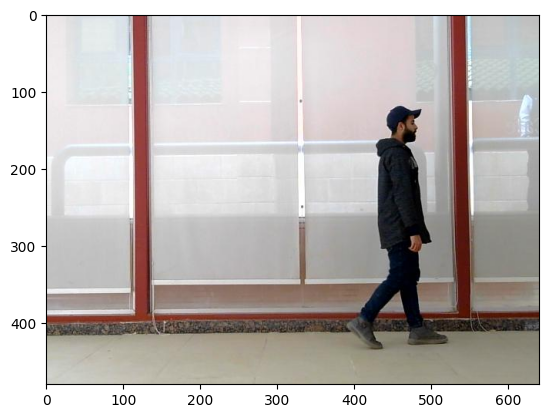

In [53]:
# seqq=np.array(sequences)
# print(seqq.shape)
# show_test = cv2.cvtColor(seqq[70][50], cv2.COLOR_BGR2RGB)
# plt.imshow(show_test)

* B) Converting to Silhouette Using KNN

In [87]:
# exported = []
# fgbg = cv2.createBackgroundSubtractorKNN()
# # fgbg = cv2.createBackgroundSubtractorKNN(history=500, dist2Threshold=300, detectShadows=True)
# # fgbg.setShadowThreshold(0.5)
# for sequence in  range(total_sequences):
# # for sequence in  range(4):
#     for frame_num in range(sequence_length):

#         frame = cv2.cvtColor(seqq[sequence][frame_num], cv2.COLOR_BGR2RGB)
#         fgmask = fgbg.apply(frame)
#         blurred_image = cv2.medianBlur(fgmask, 9)

#         exported.append(blurred_image)

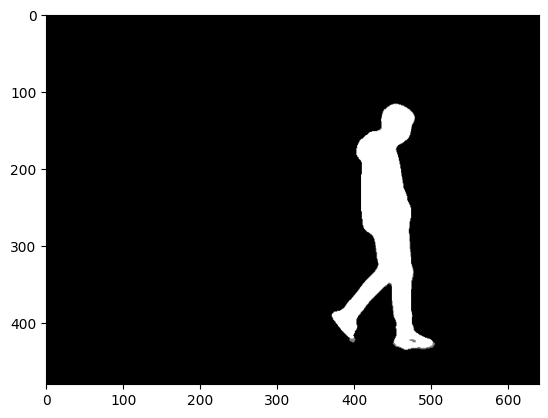

In [98]:
# plt.imshow(exported[130],cmap='gray')

In [72]:
# # Assuming each person has 10 sequences, and each sequence has 90 frames
# total_sequences = 10
# sequence_length = 90

# # Define the base directory where the images will be saved
# base_dir = "image_exports"

# # Create the base directory if it doesn't exist
# if not os.path.exists(base_dir):
#     os.makedirs(base_dir)

# # Iterate through each person
# for person_name in persons:
#     person_dir = os.path.join(base_dir, person_name)
#     # Create a directory for the person if it doesn't exist
#     if not os.path.exists(person_dir):
#         os.makedirs(person_dir)
    
#     # Iterate through each sequence for the person
#     for sequence in range(total_sequences):
#         sequence_dir = os.path.join(person_dir, f"sequence_{sequence+1}")
#         # Create a directory for the sequence if it doesn't exist
#         if not os.path.exists(sequence_dir):
#             os.makedirs(sequence_dir)
        
#         # Iterate through each frame in the sequence
#         for frame_num in range(sequence_length):
#             # Generate the filename for the frame
#             filename = f"frame_{frame_num+1}.png"
#             filepath = os.path.join(sequence_dir, filename)
            
#             # Check if there are still images in the exported array
#             if len(exported) > 0:
#                 # Retrieve and save the next image from the exported array
#                 cv2.imwrite(filepath, exported.pop(0))
#             else:
#                 # If there are no more images in the exported array, break the loop
#                 break

* C) Removing Unwanted bLacks

In [99]:
# # Function to crop silhouette images to the person
# def crop_to_person(images):
#     cropped_images = []
#     for image in images:
#         # Find contours
#         contours, _ = cv2.findContours(image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        
#         # Find the bounding box enclosing the contour
#         if contours:
#             x, y, w, h = cv2.boundingRect(contours[0])
#             cropped_image = image[y:y+h, x:x+w]
#         else:
#             # If no contours found, return original image
#             cropped_image = image
        
#         cropped_images.append(cropped_image)
    
#     return cropped_images
# cropped_images = crop_to_person(exported)


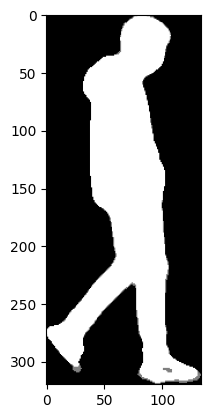

In [101]:
# plt.imshow(cropped_images[130],cmap='gray')

* E) GEI Generation

In [21]:
# def compute_gei(images):
#     # Convert images to numpy array
#     images_array = np.array(images)

#     # Compute GEI by averaging along the first axis (assuming images are stacked along the first axis)
#     gei = np.mean(images_array, axis=0)

#     return gei

In [22]:
# for frame in range(sequence_length):
#     temp = compute_gei(resized_images)
#     plt.imshow(temp,cmap='gray')

NameError: name 'resized_images' is not defined

# Train

A) Splitting Dataset

In [ ]:
# X = np.array(sequences)
# y = to_categorical(labels).astype(int)

In [ ]:
# X_train, X_test, y_train, y_test = train_test_split(X, y)
# print(X_test.shape)
# print(y_test.shape)

B) Building CNN Architecture

In [ ]:
# log_dir = os.path.join('Logs')
# tb_callback = TensorBoard(log_dir=log_dir)

In [ ]:
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import LSTM, Dense
# from tensorflow.keras.callbacks import TensorBoard

In [ ]:
# model = Sequential()
# model.add(LSTM(64, return_sequences=True, activation='relu', input_shape=(60,132)))
# model.add(LSTM(128, return_sequences=True, activation='relu'))
# model.add(LSTM(64, return_sequences=False, activation='relu'))
# model.add(Dense(64, activation='relu'))
# model.add(Dense(32, activation='relu'))
# model.add(Dense(persons.shape[0], activation='softmax'))

In [ ]:
# #Compilation
# model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])

In [ ]:
# model.fit(X_train, y_train, epochs=200, callbacks=[tb_callback])

C) Training Results

In [ ]:
# model.summary()

In [ ]:
# print("Evaluate on test data")
# results = model.evaluate(X_test, y_test, batch_size=128)
# print("test loss, test acc:", results)

In [ ]:
# res = model.predict(X_test)

In [ ]:
# persons[np.argmax(res[4])]

In [ ]:
# persons[np.argmax(y_test[4])]

In [ ]:
# model.save('train4.h5')

In [ ]:
# yhat = model.predict(X_test)

In [ ]:
# ytrue = np.argmax(y_test, axis=1).tolist()
# yhat = np.argmax(yhat, axis=1).tolist()

# multilabel_confusion_matrix(ytrue, yhat)

# accuracy_score(ytrue, yhat)

# Detection

In [ ]:
# colors = [(245,117,16),(245,117,16),(245,117,16),(245,117,16),(245,117,16),(245,117,16),(245,117,16),(245,117,16),(245,117,16),(245,117,16),(245,117,16),(245,117,16)]
# def prob_viz(res, actions, input_frame, colors):
#     output_frame = input_frame.copy()
#     for num, prob in enumerate(res):
#         cv2.rectangle(output_frame, (0,60+num*40), (int(prob*100), 90+num*40), colors[num], -1)
#         cv2.putText(output_frame, actions[num], (0, 85+num*40), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 1, cv2.LINE_AA)
        
#     return output_frame

In [ ]:
# # 1. New detection variables
# sequence = []
# sentence = []
# predictions = []
# threshold = 0.3

# cap = cv2.VideoCapture(feed)
# # Set mediapipe model
# with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
#     while cap.isOpened():

#         # Read feed
#         ret, frame = cap.read()

#         # Make detections
#         image, results = mediapipe_detection(frame, holistic)
#         print(results)
        
#         # Draw landmarks
#         draw_landmarks(image, results)
        
#         # 2. Prediction logic
#         keypoints = extract_keypoints(results)
#         sequence.append(keypoints)
#         sequence = sequence[-60:]
        
#         if len(sequence) == 60:
#             res = model.predict(np.expand_dims(sequence, axis=0))[0]
#             print(persons[np.argmax(res)])
#             predictions.append(np.argmax(res))
            
            
#         #3. Viz logic
#             if np.unique(predictions[-10:])[0]==np.argmax(res): 
#                 if res[np.argmax(res)] > threshold: 
                    
#                     if len(sentence) > 0: 
#                         if persons[np.argmax(res)] != sentence[-1]:
#                             sentence.append(persons[np.argmax(res)])
#                     else:
#                         sentence.append(persons[np.argmax(res)])

#             if len(sentence) > 5: 
#                 sentence = sentence[-5:]

#             # Viz probabilities
#             image = prob_viz(res, persons, image, colors)
            
#         cv2.rectangle(image, (0,0), (640, 40), (245, 117, 16), -1)
                
#         cv2.putText(image, ' '.join(sentence), (3,30), 
#                        cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 1, cv2.LINE_AA)
        
#         # Show to screen
#         cv2.imshow('Gait ID', image)

#         # Break gracefully
#         if cv2.waitKey(10) & 0xFF == 27:
#             break
#     cap.release()
#     cv2.destroyAllWindows()